# Is the SAT unfair? Exploring and visualizing the data to find out

### Goal of this project  

The goal of this project is to examine if the SAT (Scholastic Aptitude Test) is unfair to any particular groups of students.  

### Approach  

We will explore SAT and NYC (New York City) high school data to answer this question.  We will examine the Pearson correlation coefficients between SAT scores and the other columns in our dataset to identify the variables with the strongest connections to SAT performance.  We will then explore the strongest correlated columns further to uncover any bias in the SAT.  We will create various data visualizations, such as scatter and map plots, to aid our investigation.

### Summary of results  

At first glance, there appears to be some racial bias in the SAT, in favor of White and Asian students and against Hispanic students.  It also appears that schools with larger student populations and class sizes outperform on the SAT.  However, further analysis suggests that the socioeconomic status of the students' families and whether they are English language learners are the most relevant factors tied to SAT performance.

# Introduction to the data

The data file, `"nyc_hs_data_clean.csv"`, is located in the `"data/processed"` folder of this project.  It was produced by running the [cleaning-nyc-hs-data](https://github.com/JustinToribio/cleaning-nyc-hs-data) project, which can also be found in this GitHub repository.  

There are 362 rows (1 for each school) and 79 columns in `data`.  It contains NYC SAT results by school for the graduating seniors of 2012 in the first few columns.  At the time of this writing, this was the most recent SAT data available.  The remaining columns contain graduation, AP (advanced placement), class size, demographic, school survey and location data for the same school year (or as close to it as possible if the 2012 data was not available).  

We will read the csv file into a dataframe named `data` and view the first 5 rows.

In [1]:
# Import pandas module and set the column and row display options.
import pandas as pd
pd.options.display.max_columns = 500  
pd.options.display.max_rows = 500

# Read csv file into a dataframe named "data" and view the first 5 rows.
data = pd.read_csv("../data/processed/nyc_hs_data_clean.csv")
data.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,Advanced Regents - n,Advanced Regents - % of cohort,Advanced Regents - % of grads,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort,Num of AP Test Takers,Num of AP Total Exams Taken,Num of AP Exams Passed,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,frl_percent,total_enrollment,ell_num,ell_percent,sped_num,sped_percent,ctt_num,selfcontained_num,asian_num,asian_per,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_s_11,saf_t_11,saf_p_11,saf_tot_11,eng_s_11,eng_t_11,eng_p_11,eng_tot_11,aca_s_11,aca_t_11,aca_p_11,aca_tot_11,com_s_11,com_t_11,com_p_11,com_tot_11,lat,lon,school_dist
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29.0,355.0,404.0,363.0,1122.0,78.0,43.0,55.1,36.0,46.2,83.7,0.0,0.0,0.0,36.0,46.2,83.7,7.0,9.0,16.3,16.0,20.5,11.0,14.1,18.096134,19.175354,13.554735,88.000000,4.000000,22.564286,18.500000,26.571429,88.6,422.0,94.0,22.3,105.0,24.9,34.0,35.0,59.0,14.0,123.0,29.1,227.0,53.8,7.0,1.7,259.0,61.4,163.0,38.6,89.0,70.0,39.0,379.000000,26.0,151.0,6.00000,6.3,7.8,6.7,6.100000,6.1,7.4,6.6,6.700000,6.5,7.6,7.0,5.600000,5.3,7.7,6.2,40.713764,-73.985260,1
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91.0,383.0,423.0,366.0,1172.0,124.0,53.0,42.7,42.0,33.9,79.2,8.0,6.5,15.1,34.0,27.4,64.2,11.0,8.9,20.8,46.0,37.1,20.0,16.1,37.000000,53.000000,21.000000,105.687500,4.750000,22.231250,18.250000,27.062500,71.8,394.0,83.0,21.1,86.0,21.8,55.0,10.0,115.0,29.2,89.0,22.6,181.0,45.9,9.0,2.3,226.0,57.4,168.0,42.6,84.0,95.0,10.0,385.000000,37.0,46.0,6.00000,6.6,7.9,6.8,6.300000,6.6,7.2,6.7,7.000000,7.3,7.3,7.2,5.700000,5.8,7.4,6.3,40.712332,-73.984797,1
2,01M450,EAST SIDE COMMUNITY SCHOOL,70.0,377.0,402.0,370.0,1149.0,90.0,70.0,77.8,67.0,74.4,95.7,0.0,0.0,0.0,67.0,74.4,95.7,3.0,3.3,4.3,15.0,16.7,5.0,5.6,12.000000,12.000000,20.562084,57.600000,2.733333,21.200000,19.400000,22.866667,71.8,598.0,30.0,5.0,158.0,26.4,91.0,19.0,58.0,9.7,143.0,23.9,331.0,55.4,62.0,10.4,327.0,54.7,271.0,45.3,0.0,98.0,28.0,422.207196,42.0,150.0,6.79888,7.3,8.7,7.9,6.832925,8.0,8.1,7.9,7.594217,8.8,8.4,8.4,6.151669,8.0,8.2,7.9,40.729783,-73.983041,1
3,01M509,MARTA VALLE HIGH SCHOOL,44.0,390.0,433.0,384.0,1207.0,84.0,47.0,56.0,40.0,47.6,85.1,17.0,20.2,36.2,23.0,27.4,48.9,7.0,8.3,14.9,25.0,29.8,5.0,6.0,14.000000,15.000000,13.779655,69.642857,3.000000,23.571429,20.000000,27.357143,80.7,367.0,41.0,11.2,95.0,25.9,28.0,36.0,34.0,9.3,116.0,31.6,209.0,56.9,6.0,1.6,170.0,46.3,197.0,53.7,90.0,100.0,21.0,306.000000,29.0,69.0,6.40000,6.4,7.7,6.9,6.400000,6.1,7.2,6.6,7.000000,6.8,7.3,7.0,5.900000,5.3,7.4,6.2,40.720569,-73.985673,1
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159.0,522.0,574.0,525.0,1621.0,46.0,46.0,100.0,46.0,100.0,100.0,31.0,67.4,67.4,15.0,32.6,32.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,306.000000,587.000000,323.000000,156.368421,6.157895,25.510526,19.473684,31.210526,23.0,1613.0,4.0,0.2,43.0,2.7,2.0,0.0,448.0,27.8,189.0,11.7,229.0,14.2,725.0,44.9,794.0,49.2,819.0,50.8,98.0,68.0,51.0,923.000000,67.0,736.0,7.30000,7.6,8.5,7.8,7.000000,5.9,7.9,6.9,7.700000,7.3,8.4,7.8,6.400000,5.6,7.9,6.7,40.718725,-73.979426,1


# The SAT may be geographically biased  

We will begin by creating a color-map of mean SAT scores, by school district, on a map of NYC.  This will give us a good visualization of any geographic patterns in SAT performance.  We are plotting by school district because plotting each school will clutter the map.  We will take the mean of the latitudes, longitudes and SAT scores of the schools in a district to group the data.  

### Creating the mapping function

First we will create a function named `create_nyc_map`.  This function will generate maps with different sets of data and customization.  We will also be able to create side by side maps comparing different data sets. 

In [2]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.style as style
%matplotlib inline

import cartopy.crs as ccrs
import cartopy.feature as cfeat


def create_nyc_map(column_name_1, column_name_2=None, title=None, 
                   title_y_adj=0.0, subtitle=None, subtitle_y_adj=0.0,
                   sig_space_adj=0, map_title_1=None, map_title_2=None,
                   colorbar_ticks_1=None, colorbar_tick_labels_1=None, 
                   colorbar_ticks_2=None, colorbar_tick_labels_2=None):
    """
    Create color-mapped scatter plots (single map or two side by side 
    maps) of school districts on a map of NYC.
    
    Arguments:
    column_name_1 -- (Str) The column name from "data" to derive the 
                     first (left) scatter plot map from.
    column_name_2 -- (Str, default None) The column name from "data" to 
                     derive the second (right) scatter plot map from. If
                     None, only a map of "column_name_1" will be
                     plotted.
    title -- (Str, default None) The title of the entire plot.
    title_y_adj -- (Float, + or -, default 0.0) The amount of vertical
                   adjustment to the default position of the title, in
                   units of latitude.
    subtitle -- (Str, default None) The subtitle of the entire plot.
    subtitle_y_adj -- (Float, + or -, default 0.0) The amount of
                      vertical adjustment to the default position of the 
                      subtitle, in units of latitude.
    sig_space_adj -- (Int, + only, default 0) The amount of horizontal 
                     character space to add to the right end of the 
                     signature bar.
    map_title_1 -- (Str, default None) The title of the first (left)
                   scatter plot map. "column_name_2" must not be None.
    map_title_2 -- (Str, default None) The title of the second (right)
                   scatter plot map. "column_name_2" must not be None.
    colorbar_ticks_1 -- (List of int or float, default None) Numeric 
                        tick labels for the first (left) map's color-bar
                        legend. If None, ticks are determined
                        automatically from the input.
    colorbar_tick_labels_1 -- (List of int, float or str, default None) 
                              Custom tick labels for the first (left)
                              map's color-bar legend. The 
                              "colorbar_ticks_1" arg must be defined 
                              with a list of numeric values of at least 
                              the same length. I.e. for custom tick 
                              labels of ["10m", "20m", "30m"], 
                              "colorbar_ticks_1" must be defined with
                              [10, 20, 30] at least.
    colorbar_ticks_2 -- (List of int or float, default None) Same as
                        "colorbar_ticks_1" but for the second (right) 
                        map's color-bar legend. "column_name_2" must not
                        be None.
    colorbar_tick_labels_2 -- (List of int, float or str, default None)
                              Same as "colorbar_tick_labels_1" but for 
                              the second (right) map's color-bar legend.
                              The "colorbar_ticks_2" arg must be defined
                              with a list of numeric values of at 
                              least the same length. "column_name_2" 
                              must not be None.
    
    Returns:
    The figure object of the entire plot.
    """

    # Group the data by school district and assign the map data to
    # variables.
    districts = data.groupby("school_dist").agg(np.mean)
    districts.reset_index(inplace=True)
    longitudes = districts["lon"].tolist()
    latitudes = districts["lat"].tolist()
    nyc_boundaries = [-74.255735, -73.700272, 40.496044, 40.915256]
    state_borders = cfeat.NaturalEarthFeature(name="admin_1_states_provinces",
                                              scale="10m", category="cultural")
    signature = ("   ©Justin Toribio"
                 + " "*(2 + sig_space_adj)
                 + "Source: NYC OpenData   ")
    
    # Define the style and plotting parameters for a single map plot
    # and side by side comparison map plot.
    plt.close("all")
    style.use("fivethirtyeight")    
    if column_name_2 is None:
        second_axes = False
        figure_size = (6.5, 6.5)
        axes_1_size = [0, 0, .95, 1]
        colorbar_axes_1_size = [1, .14, .06, .72]
        title_size = 22
        subtitle_size = 16
        signature_size = 14
        signature_x_value = -74.275
    else:
        second_axes = True
        figure_size = (14, 7)
        axes_1_size = [0, 0, .43, 1]
        axes_2_size = [.55, 0, .43, 1]
        colorbar_axes_1_size = [.45, .17, .03, .66]        
        colorbar_axes_2_size = [1, .17, .03, .66]
        title_size = 25
        subtitle_size = 19
        signature_size = 16
        signature_x_value = -74.28
        
    # Create the first (left) map with scatter plot of school districts 
    # and color-bar legend.
    fig = plt.figure(figsize=figure_size)
    ax1 = fig.add_axes(axes_1_size, projection=ccrs.PlateCarree())
    ax1.background_patch.set_facecolor("lightblue")
    ax1.add_feature(state_borders, edgecolor="black", facecolor="lightgrey")
    ax1.set_extent(nyc_boundaries)
    districts_plot_1 = ax1.scatter(longitudes, latitudes, s=50, zorder=2,
                                   cmap="Reds", c=districts[column_name_1])
    colorbar_axes_1 = fig.add_axes(colorbar_axes_1_size) 
    colorbar_1 = plt.colorbar(districts_plot_1, cax=colorbar_axes_1,
                              ticks=colorbar_ticks_1)
    if (colorbar_ticks_1 is None) or (colorbar_tick_labels_1 is None):
        pass
    else:
        colorbar_1.ax.set_yticklabels(colorbar_tick_labels_1)

    # Add the title, subtitle, signature and all text of the first
    # (left) map.
    ax1.text(s=title, x=-74.255735, y=41.02+title_y_adj, fontsize=title_size,
             weight="bold", alpha=.75)
    ax1.text(s=subtitle, x=-74.255735, y=40.93+subtitle_y_adj, 
             fontsize=subtitle_size, alpha=.85)
    ax1.text(s=signature, x=signature_x_value, y=40.466, 
             fontsize=signature_size, color="#f0f0f0", backgroundcolor="grey")
    ax1.text(s="Bronx", x=-73.89, y=40.85, color="black", alpha=.8,
             weight="bold", rotation=0)
    ax1.text(s="Manhattan", x=-74.02, y=40.835, color="black", alpha=.8,
             weight="bold", rotation=55)
    ax1.text(s="Brooklyn", x=-74.013, y=40.644, color="black", alpha=.8,
             weight="bold", rotation=-10)
    ax1.text(s="Queens", x=-73.9, y=40.74, color="black", alpha=.8,
             weight="bold", rotation=-30)
    ax1.text(s="Staten Island", x=-74.2, y=40.59, color="black", alpha=.8,
             weight="bold", rotation=32)

    # Draw the boundary between Brooklyn and Queens on the first (left)
    # map.
    ax1.plot([-73.954010, -73.889662], [40.737324, 40.684499],
             color="black", linewidth=2, linestyle="dotted")
    ax1.plot([-73.889662, -73.868921], [40.684499, 40.695223],
             color="black", linewidth=2, linestyle="dotted")
    ax1.plot([-73.868921, -73.855090], [40.695223, 40.642811],
             color="black", linewidth=2, linestyle="dotted")    
    
    # If a second column name is defined, create the second (right) map 
    # with scatter plot of school districts and color-bar legend.
    if second_axes:
        ax2 = fig.add_axes(axes_2_size, projection=ccrs.PlateCarree())
        ax2.background_patch.set_facecolor("lightblue")
        ax2.add_feature(state_borders, edgecolor="black",
                        facecolor="lightgrey")
        ax2.set_extent(nyc_boundaries)
        districts_plot_2 = ax2.scatter(longitudes, latitudes, s=50, zorder=2,
                                       cmap="Reds", c=districts[column_name_2])
        colorbar_axes_2 = fig.add_axes(colorbar_axes_2_size) 
        colorbar_2 = plt.colorbar(districts_plot_2, cax=colorbar_axes_2,
                                  ticks=colorbar_ticks_2)
        if (colorbar_ticks_2 is None) or (colorbar_tick_labels_2 is None):
            pass
        else:
            colorbar_2.ax.set_yticklabels(colorbar_tick_labels_2)

        # Add the individual map titles and all text of the second
        # (right) map.
        ax1.text(s=map_title_1, x=-74.255735, y=40.925, weight="bold",
                 fontsize=subtitle_size-1, alpha=.75)
        ax2.text(s=map_title_2, x=-74.255735, y=40.925, weight="bold",
                 fontsize=subtitle_size-1, alpha=.75)
        ax2.text(s="Bronx", x=-73.89, y=40.85, color="black", alpha=.8,
                 weight="bold", rotation=0)
        ax2.text(s="Manhattan", x=-74.02, y=40.835, color="black", alpha=.8,
                 weight="bold", rotation=55)
        ax2.text(s="Brooklyn", x=-74.013, y=40.644, color="black", alpha=.8,
                 weight="bold", rotation=-10)
        ax2.text(s="Queens", x=-73.9, y=40.74, color="black", alpha=.8,
                 weight="bold", rotation=-30)
        ax2.text(s="Staten Island", x=-74.2, y=40.59, color="black", alpha=.8,
                 weight="bold", rotation=32)

        # Draw the boundary between Brooklyn and Queens on the second 
        # (right) map.
        ax2.plot([-73.954010, -73.889662], [40.737324, 40.684499],
                 color="black", linewidth=2, linestyle="dotted")
        ax2.plot([-73.889662, -73.868921], [40.684499, 40.695223],
                 color="black", linewidth=2, linestyle="dotted")
        ax2.plot([-73.868921, -73.855090], [40.695223, 40.642811],
                 color="black", linewidth=2, linestyle="dotted")        
    else:
        pass    
    plt.close("all")
        
    return fig

### Creating the map plot

Next we will call on the `create_nyc_map` function to create the map plot of SAT scores.

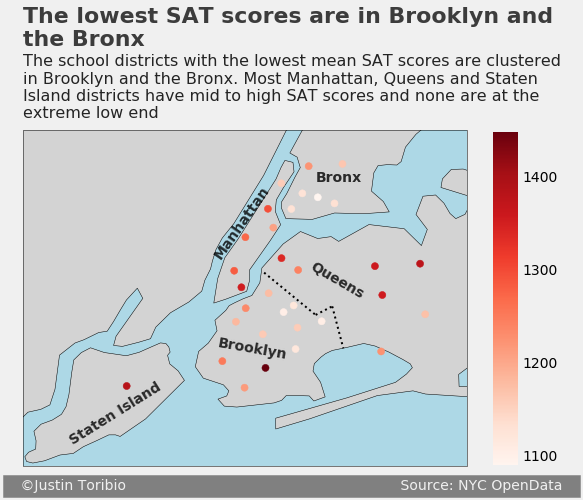

In [3]:
# Assign the title and subtitle of the map plot to variables.
title = ("The lowest SAT scores are in Brooklyn and\n"
         "the Bronx")
subtitle = (
    "The school districts with the lowest mean SAT scores are clustered\n"
    "in Brooklyn and the Bronx. Most Manhattan, Queens and Staten\n"
    "Island districts have mid to high SAT scores and none are at the\n"
    "extreme low end"
)

# Create the map plot of SAT scores.
create_nyc_map("sat_score", title=title, subtitle=subtitle, sig_space_adj=59,
               colorbar_ticks_1=[1100, 1200, 1300, 1400])

In the map above, each dot represents 1 of the 32 school districts across the 5 boroughs of NYC.  The color of each dot is a shade of red, which represents the mean SAT score across all schools in that district.  Lighter and darker red dots represent lower and higher mean SAT scores, respectively.  

The school districts with the lowest mean SAT scores are in Brooklyn and the Bronx.  Most of the districts in these 2 boroughs score on the low end of the range.  They are also the only boroughs with districts that score on the extreme low end (the near white dots).  Most districts in Manhattan, Queens and Staten Island score on the mid to high end of the range.  None are at the extreme low end.  

This geographic pattern could be explained by any number of factors: demographic, socioeconomic, educational standards, environment etc...  We will attempt to uncover the nature of any SAT bias throughout the rest of this project.  

# Finding the nature of any SAT bias  

First we will determine which columns in the data are most correlated with SAT scores.  We will create a horizontal bar plot showing the Pearson correlation coefficients between each column and the `"sat_score"` column.  

The Pearson correlation coefficient measures the linear relationship between two quantitative variables.  The maximum possible value is +1, indicating a perfect positive linear relationship.  As one variable increases, the other variable *increases* in linear proportion.  The minimum possible value is –1, indicating a perfect negative linear relationship.  As one variable increases, the other variable *decreases* in linear proportion.  A coefficient of 0 indicates no linear relationship between the two variables.  

Correlation does not necessarily indicate *causality* (that an increase in one variable *causes* an increase or decrease in the other variable).  It only indicates the strength and direction of a linear relationship between two variables.  

### Creating the correlation bar plot function  

First we will create a function named `corr_bar_plot`, which will allow us to generate the correlation bar plot with different data selections and customization.

In [4]:
import operator

def corr_bar_plot(df, target, columns=None, drop_cols=None, criteria=None,
                  threshold=0, fig_size=(7, 7), x_axis_label=None,
                  title=None, title_x_adj=0, title_y_adj=0, title_size_adj=0,
                  sub=None, sub_x_adj=0, sub_y_adj=0, sub_size_adj=0,
                  sig_space_adj=0, sig_x_adj=0, sig_y_adj=0, sig_size_adj=0):
    """
    Create a horizontal bar plot of Pearson correlation coefficients
    between the columns in a DataFrame and a target column.
    
    Arguments:
    df -- (DataFrame) The input data.
    target -- (Str) The target column label in "df". The correlations of
              the other columns will be calculated with respect to this
              column.
    columns -- (List of str, default None) The column labels from "df"
               to display in the plot. If None, all columns will be
               displayed.
    drop_cols -- (List of str, default None) The column labels from "df"
                 to remove from the plot.
    criteria -- (Str, default None) The comparison operator used to
                filter the columns displayed in the plot with respect to
                the "threshold" parameter. Can be the following values:
                    ">": greater than "threshold"
                    ">=": greater than or equal to "threshold"
                    "<": less than "threshold"
                    "<=": less than or equal to "threshold"
                    "=": equal to "threshold"
                    "abs": greater than or equal to the absolute value
                           of "threshold"
    threshold -- (Float, default 0) The numeric cutoff value to filter
                 the columns in the plot by. The "criteria" parameter
                 must not be None.
    fig_size -- (Tuple of floats, default (7, 7)) The (width, height)
                dimensions of the plot.
    x_axis_label -- (Str, default None) The label for the x-axis.
    title -- (Str, default None) The title of the plot.
    title_x_adj -- (Float, + or -, default 0) The amount of horizontal
                   adjustment to the default position of the title.
    title_y_adj -- (Float, + or -, default 0) The amount of vertical
                   adjustment to the default position of the title.
    title_size_adj -- (Float, + or -, default 0) The amount of
                      adjustment to the default font size of the title.
    sub -- (Str, default None) The subtitle of the plot.
    sub_x_adj -- (Float, + or -, default 0) The amount of horizontal
                 adjustment to the default position of the subtitle.
    sub_y_adj -- (Float, + or -, default 0) The amount of vertical
                 adjustment to the default position of the subtitle.
    sub_size_adj -- (Float, + or -, default 0) The amount of adjustment
                    to the default font size of the sub title.
    sig_space_adj -- (Int, + only, default 0) The amount of horizontal 
                     character space to add to the right end of the 
                     signature bar.
    sig_x_adj -- (Float, + or -, default 0) The amount of horizontal
                 adjustment to the default position of the signature
                 bar.
    sig_y_adj -- (Float, + or -, default 0) The amount of vertical
                 adjustment to the default position of the signature
                 bar.
    sig_size_adj -- (Float, + or -, default 0) The amount of adjustment
                    to the default font size of the signature bar.
    
    Returns:
    None. The bar plot will be displayed when the function is called
    in a Jupyter Notebook with the "%matplotlib inline" magic.
    """
    
    # Assign the comparison operator dictionary and signature text to
    # variables.
    operator_dict = {">": operator.gt,
                     "<": operator.lt,
                     ">=": operator.ge,
                     "<=": operator.le,
                     "=": operator.eq}
    signature = ("   ©Justin Toribio"
                 + " "*(2 + sig_space_adj)
                 + "Source: NYC OpenData   ")
    
    # Define the correlation dataset based on the values of the function
    # parameters.
    corr = df.corr()[target]    
    if columns is None:
        pass
    else:
        corr = corr[columns]        
    if drop_cols is None:
        pass
    else:
        corr.drop(drop_cols, inplace=True)    
    if criteria is None:
        pass
    elif criteria == "abs":
        corr = corr[abs(corr) >= threshold]
    else:
        corr = corr[operator_dict[criteria](corr, threshold)]
        
    # Create and display the correlation bar plot.
    plt.close("all")
    style.use("fivethirtyeight")
    graph = corr.plot.barh(figsize=fig_size)
    graph.set_xlabel(x_axis_label, labelpad=13)
    graph.text(s=title, x=title_x_adj, y=5+title_y_adj,
               fontsize=22+title_size_adj, weight="bold", alpha=.75)
    graph.text(s=sub, x=sub_x_adj, y=3+sub_y_adj, fontsize=17+sub_size_adj,
               alpha=.85)
    graph.text(s=signature, x=sig_x_adj, y=-4+sig_y_adj, color="#f0f0f0",
               fontsize=14+sig_size_adj, backgroundcolor="grey")
    
    return None

### Creating the correlation bar plot  

Next we will call on the `corr_bar_plot` function to create the correlation bar plot.  Since we are trying to find evidence of bias in the SAT, we will only show columns with an absolute correlation greater than 0.4 with `"sat_score"`.  We will also filter out any columns about the SAT, since that is our target variable.

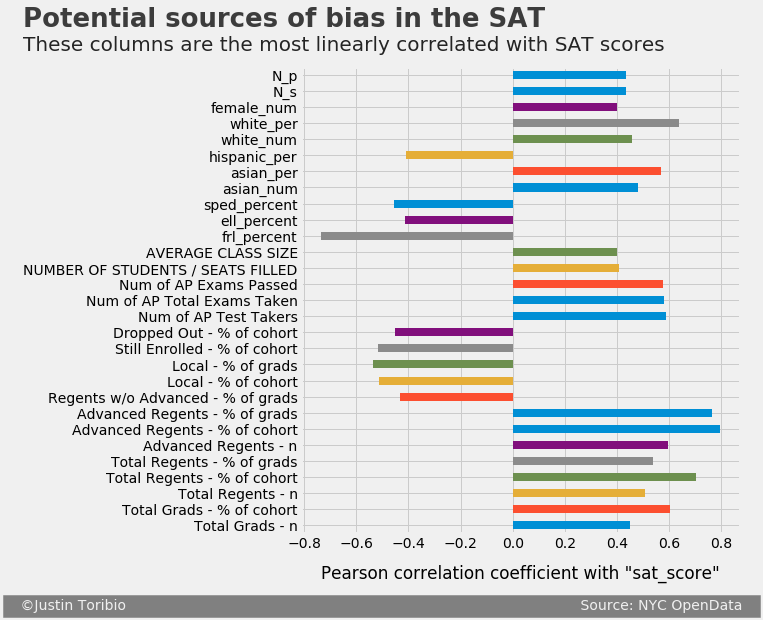

In [5]:
# Assign the list of column names to drop and the text of the bar plot
# to variables.
drop_columns = ["sat_score", "SAT Writing Avg. Score", 
                "SAT Critical Reading Avg. Score", "SAT Math Avg. Score",
                "Num of SAT Test Takers"]
title = "Potential sources of bias in the SAT"
subtitle = "These columns are the most linearly correlated with SAT scores"
x_axis_label = 'Pearson correlation coefficient with "sat_score"'

# Create and display the bar plot.
corr_bar_plot(data, "sat_score", criteria="abs", threshold=.4, fig_size=(7, 8),
              drop_cols=drop_columns, x_axis_label=x_axis_label,
              title=title, title_x_adj=-1.88, title_y_adj=26, title_size_adj=4,
              sub=subtitle, sub_x_adj=-1.88, sub_y_adj=26.5, sub_size_adj=3,
              sig_x_adj=-1.94, sig_y_adj=-1.25, sig_space_adj=99)

The column names in the bar plot above can be grouped into the following categories of data: survey, demographic, class size, AP (advanced placement) and graduation.  We will explore each category in the following sections.  

# School survey participation may influence SAT scores  

The first 2 column names in the correlation bar plot above (`"N_p"` and `"N_s"`) both pertain to survey data.  We will display the bar plot again showing only these 2 columns.

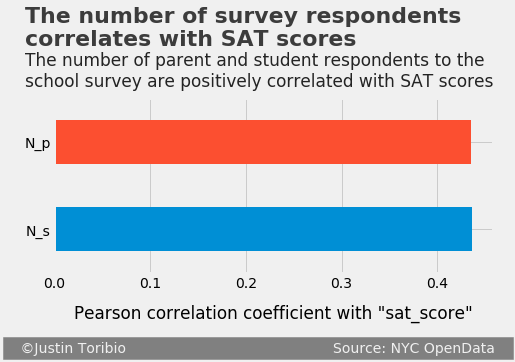

In [6]:
# Assign the column names to be viewed and the text of the bar plot to
# variables.
columns = ["N_s", "N_p"]
title = ("The number of survey respondents\n"
         "correlates with SAT scores")
subtitle = ("The number of parent and student respondents to the\n"
            "school survey are positively correlated with SAT scores\n")
x_axis_label = 'Pearson correlation coefficient with "sat_score"'

# Create and display the bar plot.
corr_bar_plot(data, "sat_score", columns=columns,
              fig_size=(7, 3), x_axis_label=x_axis_label,
              title=title, title_y_adj=-2.9, title_x_adj=-.03,
              sub=subtitle, sub_y_adj=-1.6, sub_x_adj=-.03,
              sig_y_adj=2.6, sig_x_adj=-.049, sig_space_adj=44)

`"N_p"` and `"N_s"` are the numbers of parent and student respondents to the school survey, respectively.  Both are positively correlated with SAT scores.  

Looking at the "number" of respondents may be misleading since schools will have different student population sizes.  We will look at response "rates" so that comparisons between schools are commensurate.  The response rates for parents and students are represented by the columns `"rr_p"` and `"rr_s"`, respectively.  We will re-create the correlation bar plot including these 2 columns.

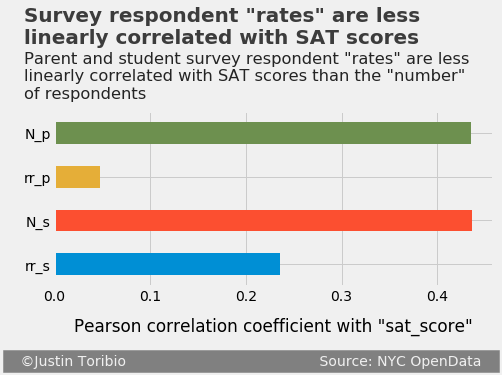

In [7]:
# Assign the column names to be viewed and the text of the bar plot to
# variables.
columns = ["rr_s", "N_s", "rr_p", "N_p"]
title = ('Survey respondent "rates" are less\n'
         'linearly correlated with SAT scores')
subtitle = ('Parent and student survey respondent "rates" are less\n'
            'linearly correlated with SAT scores than the "number"\n'
            'of respondents')
x_axis_label = 'Pearson correlation coefficient with "sat_score"'

# Create and display the bar plot.
corr_bar_plot(data, "sat_score", columns=columns, fig_size=(7, 3),
              x_axis_label=x_axis_label, title=title,
              title_y_adj=.05, title_x_adj=-.031, title_size_adj=-2,
              sub=subtitle, sub_y_adj=.8, sub_x_adj=-.031, sub_size_adj=-.7,
              sig_y_adj=1.7, sig_x_adj=-.049, sig_space_adj=41)

The parent and student survey respondent "rates" are significantly less linearly correlated with SAT scores than the corresponding "number" of respondents.  The correlation coefficients of both rates are below the initial 0.4 threshold that we set.

Next we will look at scatter plots of the parent and student respondent rates against SAT scores.  We will look for any non-linear relationships between these 2 variables and SAT results.

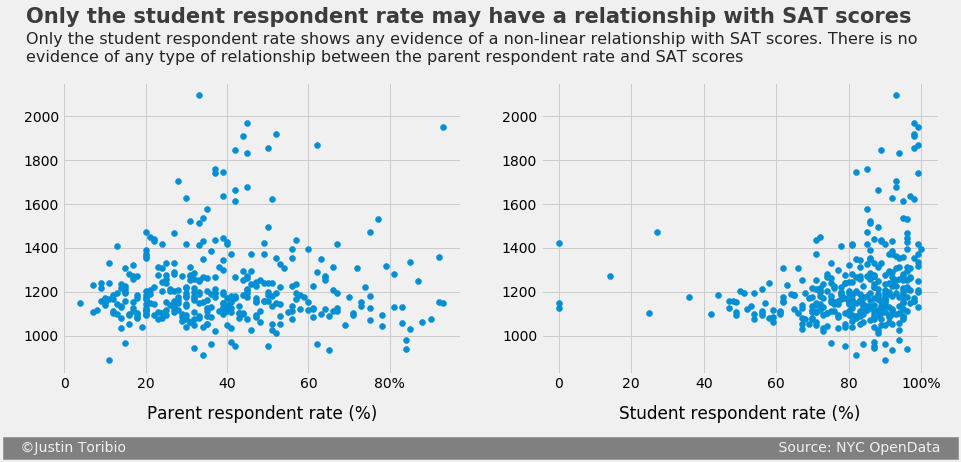

In [8]:
# Assign the text of the scatter plots to variables.
title = ("Only the student respondent rate may have a relationship with SAT"
         " scores")
subtitle = ("Only the student respondent rate shows any evidence of a" 
            " non-linear relationship with SAT scores. There is no\n" 
            "evidence of any type of relationship between the"
            " parent respondent rate and SAT scores")
x_axis_label_1 = "Parent respondent rate (%)"
x_axis_label_2 = "Student respondent rate (%)"
signature = ("   ©Justin Toribio"
             + " "*145
             + "Source: NYC OpenData   ")

# Define the plot style and create the figure object.
plt.close("all")
style.use("fivethirtyeight")
fig = plt.figure(figsize=(14,5))

# Create the left scatter plot and add the text of the entire plot.
ax1 = fig.add_subplot(121)
ax1.scatter(data["rr_p"], data["sat_score"])
ax1.set_xticklabels(labels=["-20", "0", "20", "40", "60", "80%"])
ax1.set_xlabel(x_axis_label_1, labelpad=14)
ax1.yaxis.label.set_visible(False)
ax1.text(s=title, x=-9.5, y=2425, fontsize=21, weight="bold", alpha=.75)
ax1.text(s=subtitle, x=-9.5, y=2250, fontsize=16, alpha=.85)
ax1.text(s=signature, x=-14, y=470, fontsize=14, color="#f0f0f0",
         backgroundcolor="grey")

# Create the right scatter plot and display the entire plot.
ax2 = fig.add_subplot(122)
ax2.scatter(data["rr_s"], data["sat_score"])
ax2.set_xticklabels(labels=["-20", "0", "20", "40", "60", "80", "100%"])
ax2.set_xlabel(x_axis_label_2, labelpad=14)
ax2.yaxis.label.set_visible(False)
plt.show()

There is no evidence of any type of relationship between the parent respondent rate and SAT scores.  There is some evidence of a non-linear relationship between the student respondent rate and SAT scores.  The only schools with mean SAT scores above 1500 have a student respondent rate above 80%.  All schools with a student respondent rate 80% or below have mean SAT scores below 1500.

This does not mean that all schools with high student respondent rates will have high SAT scores.  Likewise, having low SAT scores does not necessarily mean low student respondent rates.  The only conclusion we can make is: if a school has a really high mean SAT score, it probably has a very high student respondent rate.  If a school has a really low student respondent rate, it probably does not have a high mean SAT score.  

This makes intuitive sense.  Schools with high mean SAT scores are likely to have many students that take their education seriously.  Thus, they would be willing to participate in the survey to assist in their schools' improvement.  In contrast, schools with lower student respondent rates may indicate the students lack engagement and interest in their education.  This could also translate to poorer SAT preparation.  

# Exploring demographic data and SAT scores  

The 3rd through 11th column names in the [initial correlation bar plot above](#Creating-the-correlation-bar-plot) (`"female_num"` to `"frl_percent"`) all pertain to demographic data.  We will display the bar plot again showing only these columns.

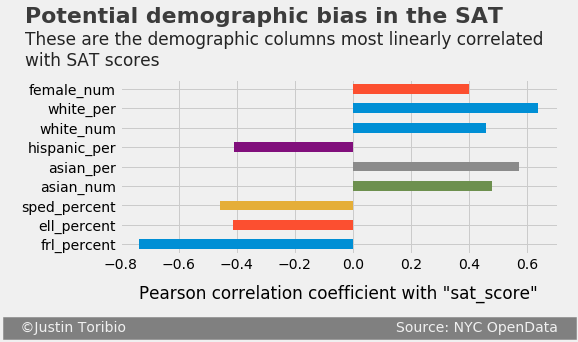

In [9]:
# Assign the column names to be viewed and the text of the bar plot to
# variables.
columns = ["frl_percent", "ell_percent", "sped_percent", "asian_num",
           "asian_per", "hispanic_per", "white_num", "white_per", "female_num"]
title = "Potential demographic bias in the SAT"
subtitle = ("These are the demographic columns most linearly correlated\n"
            "with SAT scores")
x_axis_label = 'Pearson correlation coefficient with "sat_score"'

# Create and display the bar plot.
corr_bar_plot(data, "sat_score", columns=columns,
              fig_size=(7, 3), x_axis_label=x_axis_label,
              title=title, title_y_adj=6.4, title_x_adj=-1.13,
              sub=subtitle, sub_y_adj=6.2, sub_x_adj=-1.13,
              sig_y_adj=-.5, sig_x_adj=-1.19, sig_space_adj=58)

The column names in the bar plot above can be grouped into the following categories of demographic data: Female, White, Hispanic, Asian, Special Education, English Language Learner, and Free or Reduced Price Lunch.  

We will ignore the Special Education data (`"sped_percent"`), which is negatively correlated with SAT scores.  Special Education is a form of learning provided to students with exceptional needs, including students with learning disabilities or mental challenges.  We expect schools with higher proportions of Special Education students to have lower mean SAT scores.  So there is not much insight to gain here.

We will explore the remaining demographic categories in the following sub-sections.  

## More female students may mean higher SAT scores  

The `"female_num"` column represents the total number of female students in the school.  It has a positive correlation with `"sat_score"` of approximately 0.4.  However, we want to look at the female student percentages to account for differences in school population sizes.  The `"female_per"` column represents this data.  

We will re-create the correlation bar plot including only these 2 columns.

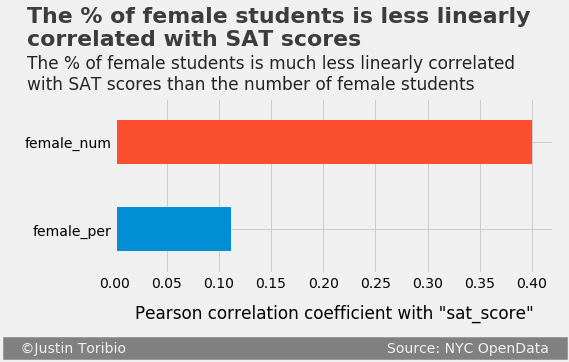

In [10]:
# Assign the column names to be viewed and the text of the bar plot to
# variables.
columns = ["female_per", "female_num"]
title = ("The % of female students is less linearly\n"
         "correlated with SAT scores")
subtitle = ("The % of female students is much less linearly correlated\n"
            "with SAT scores than the number of female students")
x_axis_label = 'Pearson correlation coefficient with "sat_score"'

# Create and display the bar plot.
corr_bar_plot(data, "sat_score", columns=columns,
              fig_size=(7, 3), x_axis_label=x_axis_label,
              title=title, title_y_adj=-2.9, title_x_adj=-.084,
              sub=subtitle, sub_y_adj=-1.4, sub_x_adj=-.084,
              sig_y_adj=2.6, sig_x_adj=-.103, sig_space_adj=56)

Female student percentages are much less linearly correlated with SAT scores than the number of female students.  Next we will look at a scatter plot of female student percentages against SAT scores.  We will see if there is any evidence of a non-linear relationship between the 2 variables.

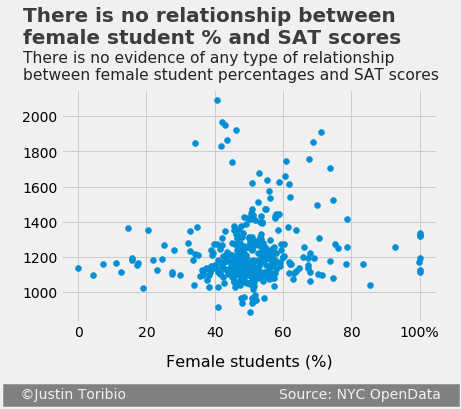

In [11]:
# Assign the text of the scatter plot to variables.
title = ("There is no relationship between\n"
         "female student % and SAT scores")
subtitle = ("There is no evidence of any type of relationship\n"
            "between female student percentages and SAT scores")
x_axis_label_1 = "Female students (%)"
signature = ("   ©Justin Toribio"
             + " "*34
             + "Source: NYC OpenData   ")

# Define the plot style and create the figure object.
plt.close("all")
style.use("fivethirtyeight")
fig = plt.figure(figsize=(6,4))

# Create the scatter plot, add the text and display the plot.
ax1 = fig.add_subplot(111)
ax1.scatter(data["female_per"], data["sat_score"])
ax1.set_xticklabels(labels=["-20", "0", "20", "40", "60", "80", "100%"])
ax1.set_xlabel(x_axis_label_1, labelpad=14, fontsize=16)
ax1.yaxis.label.set_visible(False)
ax1.text(s=title, x=-16, y=2415, fontsize=20, weight="bold", alpha=.75)
ax1.text(s=subtitle, x=-16, y=2210, fontsize=15.5, alpha=.85)
ax1.text(s=signature, x=-20.75, y=390, fontsize=14, color="#f0f0f0",
         backgroundcolor="grey")
plt.show()

There is no evidence of any type of relationship between female student percentages and SAT scores.  The only noticeable pattern is that all schools with a heavy concentration in either sex (greater than 80% or less than 30% female) have mean SAT scores below 1400. This suggests there could be a connection between sexual diversity in a school and SAT performance.

## English Language Learners and Reduced Price Lunches may explain SAT racial bias  

Looking at the [correlation bar plot](#Exploring-demographic-data-and-SAT-scores), there appears to be some racial bias in the SAT in favor of White and Asian students, and against Hispanic students.  However, the `"ell_percent"` column (% of students that are English Language Learners) and `"frl_percent"` column (% of students that receive free or reduced price lunches) are particularly interesting.  You can draw very logical connections between these factors and SAT performance.  They could also explain the potential racial bias we see.  

We expect English Language Learners to have difficulty on a test written in English, such as the SAT.  [Students are eligible to receive free or reduced price lunches if their families' incomes are close enough to the established poverty line](https://otda.ny.gov/workingfamilies/schoollunch.asp).  Students receiving free or reduced price lunches means they are from low-income families, which means they probably have less access to academic resources (i.e. tutors, computers, school supplies etc...).  Schools with a high % of students from low-income families could mean they are located in low-income neighborhoods.  So these schools may lack the necessary financial resources to support quality education standards.  All of these factors would naturally lead to poorer SAT performance.

We will view the scatter plots of `"ell_percent"` and `"frl_percent"` against `"sat_score"` to get a visual representation of their relationships.

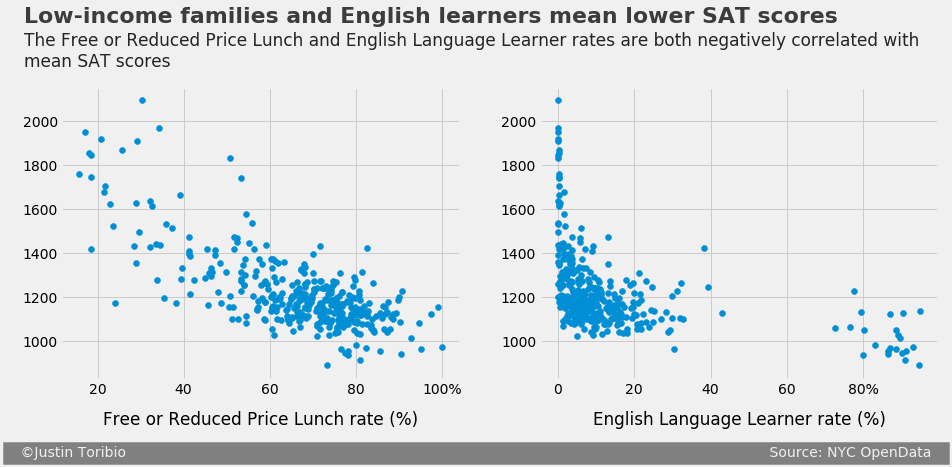

In [12]:
# Assign the text of the scatter plots to variables.
title = "Low-income families and English learners mean lower SAT scores"
subtitle = ("The Free or Reduced Price Lunch and English Language Learner"
            " rates are both negatively correlated with\n"
            "mean SAT scores")
x_axis_label_1 = "Free or Reduced Price Lunch rate (%)"
x_axis_label_2 = "English Language Learner rate (%)"
signature = ("   ©Justin Toribio"
             + " "*143
             + "Source: NYC OpenData   ")

# Define the plot style and create the figure object.
plt.close("all")
style.use("fivethirtyeight")
fig = plt.figure(figsize=(14,5))

# Create the left scatter plot and add the text of the entire plot.
ax1 = fig.add_subplot(121)
ax1.scatter(data["frl_percent"], data["sat_score"])
ax1.set_xticklabels(labels=["0", "20", "40", "60", "80", "100%"])
ax1.set_xlabel(x_axis_label_1, labelpad=14)
ax1.yaxis.label.set_visible(False)
ax1.text(s=title, x=3, y=2450, fontsize=22, weight="bold", alpha=.75)
ax1.text(s=subtitle, x=3, y=2250, fontsize=17, alpha=.85)
ax1.text(s=signature, x=-1, y=470, fontsize=14, color="#f0f0f0",
         backgroundcolor="grey")

# Create the right scatter plot and display the entire plot.
ax2 = fig.add_subplot(122)
ax2.scatter(data["ell_percent"], data["sat_score"])
ax2.set_xticklabels(labels=["-20", "0", "20", "40", "60", "80%"])
ax2.set_xlabel(x_axis_label_2, labelpad=14)
ax2.yaxis.label.set_visible(False)
plt.show()

The Free or Reduced Price Lunch (herein referred to as "FRL") and English Language Learner (herein referred to as "ELL") rates are both negatively correlated with mean SAT scores.  

The FRL rate has a stronger negative linear correlation (approximately -0.7).  There is a very clear downward linear trend in mean SAT scores as FRL rates increase.  All schools with an FRL rate above 59% have mean SAT scores below 1500.  The only schools with mean SAT scores above 1500 have FRL rates below 59%.  This is consistent with our hypothesis about the relationship between these 2 variables.  

The ELL rate has a weaker negative linear correlation (approximately -0.41).  There is more of a non-linear negative relationship between the 2 variables.  Most of the schools are clustered in an ELL rate range between 0 to 30%.  All schools with an ELL rate above 10% have mean SAT scores below 1500.  The only schools with mean SAT scores above 1600 have ELL rates at or close to 0%.  This is consistent with our hypothesis about the relationship between these 2 variables.  

Next we will view the scatter plots of the 3 racial columns against `"sat_score"` to get a visual representation of their relationships.

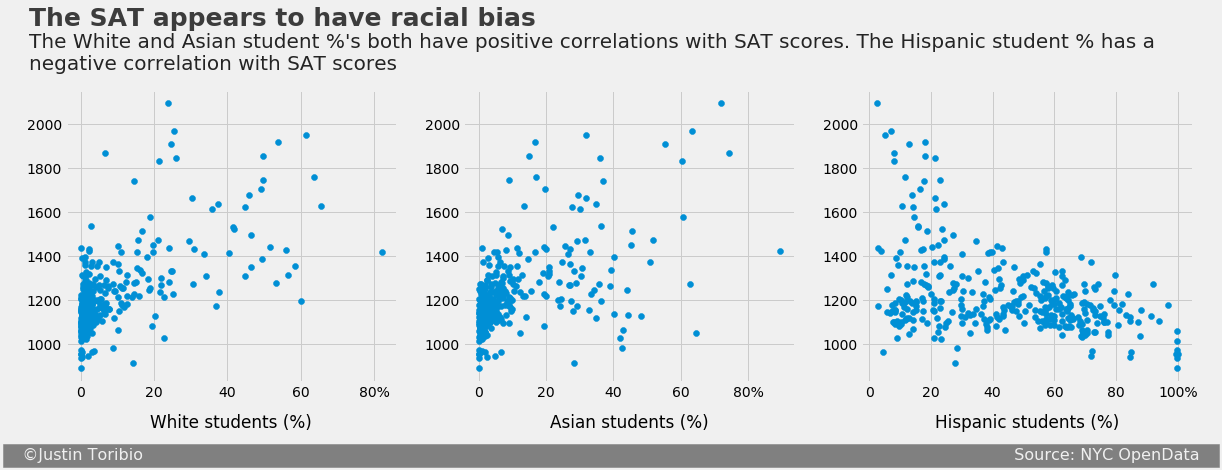

In [13]:
# Assign the text of the scatter plots to variables.
title = "The SAT appears to have racial bias"
subtitle = ("The White and Asian student %'s both have positive correlations"
            " with SAT scores. The Hispanic student % has a\n"
            "negative correlation with SAT scores")
x_axis_label_1 = "White students (%)"
x_axis_label_2 = "Asian students (%)"
x_axis_label_3 = "Hispanic students (%)"
signature = ("   ©Justin Toribio"
             + " "*170
             + "Source: NYC OpenData   ")

# Define the plot style and create the figure object.
plt.close("all")
style.use("fivethirtyeight")
fig = plt.figure(figsize=(18,5))

# Create the left scatter plot and add the text of the entire plot.
ax1 = fig.add_subplot(131)
ax1.scatter(data["white_per"], data["sat_score"])
ax1.set_xticklabels(labels=["-20", "0", "20", "40", "60", "80%"])
ax1.set_xlabel(x_axis_label_1, labelpad=14)
ax1.yaxis.label.set_visible(False)
ax1.text(s=title, x=-14, y=2450, fontsize=25, weight="bold", alpha=.75)
ax1.text(s=subtitle, x=-14, y=2250, fontsize=20, alpha=.85)
ax1.text(s=signature, x=-20, y=470, fontsize=16, color="#f0f0f0",
         backgroundcolor="grey")

# Create the middle scatter plot.
ax2 = fig.add_subplot(132)
ax2.scatter(data["asian_per"], data["sat_score"])
ax2.set_xticklabels(labels=["-20", "0", "20", "40", "60", "80%"])
ax2.set_xlabel(x_axis_label_2, labelpad=14)
ax2.yaxis.label.set_visible(False)

# Create the right scatter plot and display the entire plot.
ax3 = fig.add_subplot(133)
ax3.scatter(data["hispanic_per"], data["sat_score"])
ax3.set_xticklabels(labels=["-20", "0", "20", "40", "60", "80", "100%"])
ax3.set_xlabel(x_axis_label_3, labelpad=14)
ax3.yaxis.label.set_visible(False)
plt.show()

At first glance it appears there is some racial bias in the SAT.  There is an upward trend between the White and Asian student percentages and SAT scores, although not that strong.  The minimum SAT score increases as either the White student percentage or Asian student percentage increases.

In contrast, there is a downward trend between the Hispanic student percentage and SAT scores.  The maximum mean SAT score declines as the Hispanic student percentage increases.  All schools with a Hispanic student percentage greater than 30% have a mean SAT score less than 1500.  The only schools with mean SAT scores greater than 1500 have Hispanic student percentages less than 30%.  

However, before concluding that the SAT is racially discriminatory, let's explore if there is a relationship between each of the 3 racial groups and our 2 initial demographic variables of interest: FRL (Free or Reduced Price Lunch) and ELL (English Language Learners).  First we will view the correlation coefficient bar plots between the 3 racial groups and the FRL and ELL rates.

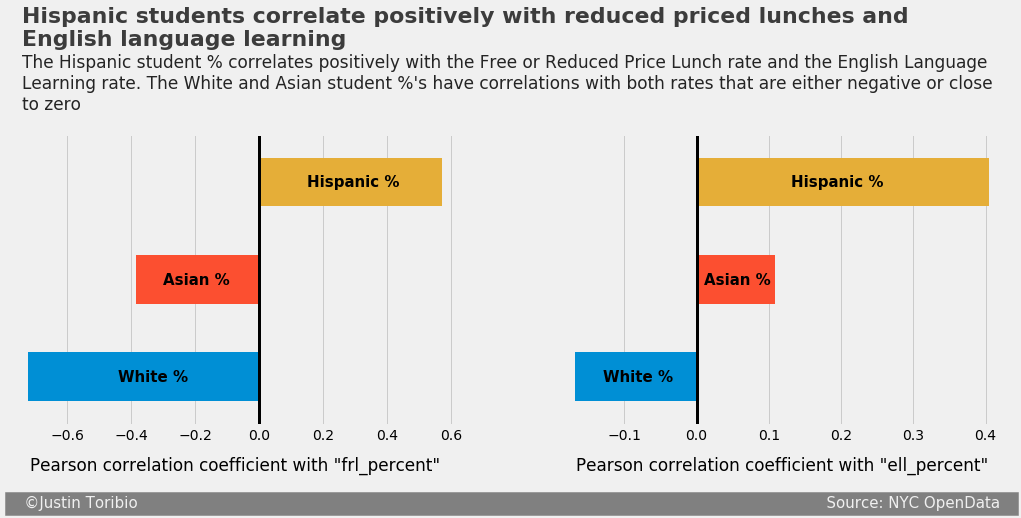

In [14]:
# Assign the text of the bar plots to variables.
title = ("Hispanic students correlate positively with reduced priced"
         " lunches and\n"
         "English language learning")
subtitle = ("The Hispanic student % correlates positively with the Free or"
            " Reduced Price Lunch rate and the English Language\n"
            "Learning rate. The White and Asian student %'s have correlations"
            " with both rates that are either negative or close\n"
            "to zero")
x_axis_label_1 = 'Pearson correlation coefficient with "frl_percent"'
x_axis_label_2 = 'Pearson correlation coefficient with "ell_percent"'
signature = ("   ©Justin Toribio"
             + " "*145
             + "Source: NYC OpenData   ")

# Define the plot style and create the figure object.
plt.close("all")
style.use("fivethirtyeight")
fig = plt.figure(figsize=(16,5))

# Create the left bar plot and add the text of the entire plot.
corr = data.corr()["frl_percent"]
corr = corr[["white_per", "asian_per", "hispanic_per"]]
ax1 = fig.add_subplot(121)
ax1 = corr.plot.barh()
ax1.set_xlabel(x_axis_label_1, labelpad=14)
ax1.get_yaxis().set_visible(False)
ax1.plot([0, 0], [-.5, 3.5], color="black", linewidth=3)
ax1.text(s="Hispanic %", x=0.15, y=1.95, fontsize=15, weight="bold")
ax1.text(s="Asian %", x=-0.3, y=0.95, fontsize=15, weight="bold")
ax1.text(s="White %", x=-0.44, y=-.05, fontsize=15, weight="bold")
ax1.text(s=title, x=-.74, y=3.4, fontsize=22, weight="bold", alpha=.75)
ax1.text(s=subtitle, x=-.74, y=2.75, fontsize=17, alpha=.85)
ax1.text(s=signature, x=-.78, y=-1.35, fontsize=15, color="#f0f0f0",
         backgroundcolor="grey")

# Create the right bar plot and display the entire plot.
corr = data.corr()["ell_percent"]
corr = corr[["white_per", "asian_per", "hispanic_per"]]
ax2 = fig.add_subplot(122)
ax2 = corr.plot.barh()
ax2.set_xlabel(x_axis_label_2, labelpad=14)
ax2.get_yaxis().set_visible(False)
ax2.plot([0, 0], [-.5, 3.5], color="black", linewidth=3)
ax2.text(s="Hispanic %", x=0.13, y=1.95, fontsize=15, weight="bold")
ax2.text(s="Asian %", x=0.01, y=0.95, fontsize=15, weight="bold")
ax2.text(s="White %", x=-0.13, y=-.05, fontsize=15, weight="bold")
plt.show()

Hispanic student percentages correlate positively with both the FRL and ELL rates.  In contrast, the White and Asian student percentages have correlations with both rates that are either negative or close to zero.  This suggests that the apparent racial bias we see in SAT results isn't really tied to inherent racial discrimination in the test.  Rather, the propensity for each group to come from low-income households or to be learning the English language could be the real source of the bias.  

Next we will view the scatter plots between the 3 racial groups and the FRL and ELL rates to get a visual representation of their relationships.

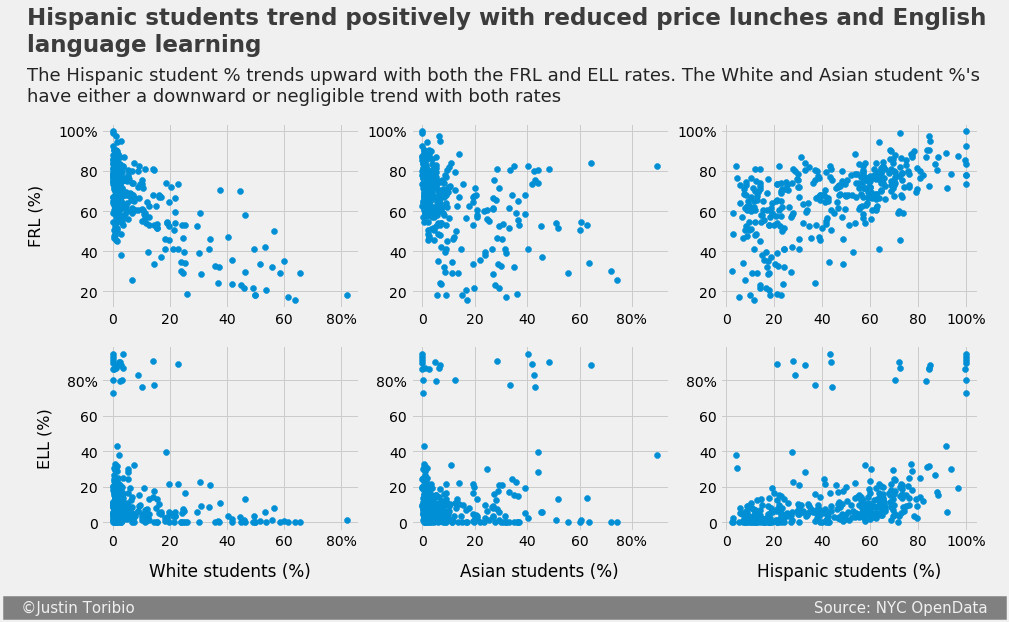

In [15]:
# Assign the text of the scatter plots to variables.
title = ("Hispanic students trend positively with reduced price lunches and"
         " English\n"
         "language learning")
subtitle = ("The Hispanic student % trends upward with both the FRL and ELL"
            " rates. The White and Asian student %'s\n"
            "have either a downward or negligible trend with both rates")
x_axis_label_1 = "White students (%)"
x_axis_label_2 = "Asian students (%)"
x_axis_label_3 = "Hispanic students (%)"
y_axis_label_1 = "FRL (%)"
y_axis_label_2 = "ELL (%)"
signature = ("   ©Justin Toribio"
             + " "*143
             + "Source: NYC OpenData   ")

# Define the plot style and create the figure object.
plt.close("all")
style.use("fivethirtyeight")
fig = plt.figure(figsize=(14,7))

# Create the top left scatter plot and add the text of the entire plot.
ax1 = fig.add_subplot(231)
ax1.scatter(data["white_per"], data["frl_percent"])
ax1.set_xticklabels(labels=["-20", "0", "20", "40", "60", "80%"])
ax1.set_yticklabels(labels=["0", "20", "40", "60", "80", "100%"])
ax1.set_ylabel(y_axis_label_1, labelpad=14, fontsize=16)
ax1.text(s=title, x=-30, y=140, fontsize=23, weight="bold", alpha=.75)
ax1.text(s=subtitle, x=-30, y=115, fontsize=18, alpha=.85)
ax1.text(s=signature, x=-37, y=-140, fontsize=15, color="#f0f0f0",
         backgroundcolor="grey")

# Create the top middle scatter plot.
ax2 = fig.add_subplot(232)
ax2.scatter(data["asian_per"], data["frl_percent"])
ax2.set_xticklabels(labels=["-20", "0", "20", "40", "60", "80%"])
ax2.set_yticklabels(labels=["0", "20", "40", "60", "80", "100%"])
ax2.yaxis.label.set_visible(False)

# Create the top right scatter plot.
ax3 = fig.add_subplot(233)
ax3.scatter(data["hispanic_per"], data["frl_percent"])
ax3.set_xticklabels(labels=["-20", "0", "20", "40", "60", "80", "100%"])
ax3.set_yticklabels(labels=["0", "20", "40", "60", "80", "100%"])
ax3.yaxis.label.set_visible(False)

# Create the bottom left scatter plot.
ax4 = fig.add_subplot(234)
ax4.scatter(data["white_per"], data["ell_percent"])
ax4.set_xticklabels(labels=["-20", "0", "20", "40", "60", "80%"])
ax4.set_yticklabels(labels=["-20", "0", "20", "40", "60", "80%"])
ax4.set_xlabel(x_axis_label_1, labelpad=14)
ax4.set_ylabel(y_axis_label_2, labelpad=14, fontsize=16)

# Create the bottom middle scatter plot.
ax5 = fig.add_subplot(235)
ax5.scatter(data["asian_per"], data["ell_percent"])
ax5.set_xticklabels(labels=["-20", "0", "20", "40", "60", "80%"])
ax5.set_yticklabels(labels=["-20", "0", "20", "40", "60", "80%"])
ax5.set_xlabel(x_axis_label_2, labelpad=14)
ax5.yaxis.label.set_visible(False)

# Create the bottom right scatter plot and display the entire plot.
ax6 = fig.add_subplot(236)
ax6.scatter(data["hispanic_per"], data["ell_percent"])
ax6.set_xticklabels(labels=["-20", "0", "20", "40", "60", "80", "100%"])
ax6.set_yticklabels(labels=["-20", "0", "20", "40", "60", "80%"])
ax6.set_xlabel(x_axis_label_3, labelpad=14)
ax6.yaxis.label.set_visible(False)
plt.show()

Hispanic student percentages have a clear upward trend with FRL rates (top right plot).  There is also an upward trend with the ELL rate (bottom right plot), although not as strong.  In contrast, the White and Asian student percentages have either downward or negligible trends with both rates.  This further supports our theory that the apparent racial bias in the SAT is actually explained by the FRL and ELL rates.  

Next we will display the data on maps of NYC to see if the geographic patterns are consistent with our findings.  We will start by comparing the map of SAT scores with the map of Hispanic student percentages.

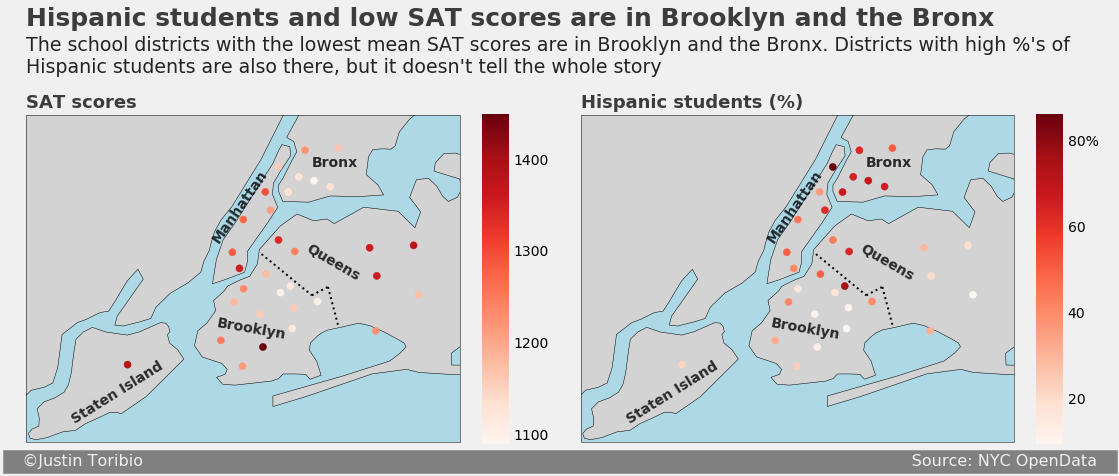

In [16]:
# Assign the title and subtitle of the map plot to variables.
title = "Hispanic students and low SAT scores are in Brooklyn and the Bronx"
subtitle = ("The school districts with the lowest mean SAT scores are in" 
            " Brooklyn and the Bronx. Districts with high %'s of\n"
            "Hispanic students are also there, but it doesn't tell the whole"
            " story")

# Create and display the side by side map plot.
create_nyc_map("sat_score", "hispanic_per", title=title,
               title_y_adj=.01, subtitle=subtitle, subtitle_y_adj=.04,
               sig_space_adj=148, map_title_1="SAT scores", 
               map_title_2="Hispanic students (%)",
               colorbar_ticks_1=[1100, 1200, 1300, 1400], 
               colorbar_ticks_2=[20, 40, 60, 80], 
               colorbar_tick_labels_2=[20, 40, 60, "80%"])

As we discovered before, the lowest mean SAT scores come from Brooklyn and the Bronx (left map).  Districts with high concentrations of Hispanic students are also in those boroughs (right map).  However, there are many districts in Brooklyn that have low Hispanic student concentrations as well as low mean SAT scores.  This suggests there is more to the story than Hispanic students simply performing poorly on the SAT or the SAT having a racial bias.

Next we will compare the map of SAT scores with the map of FRL (Free or Reduced Price Lunch) rates.

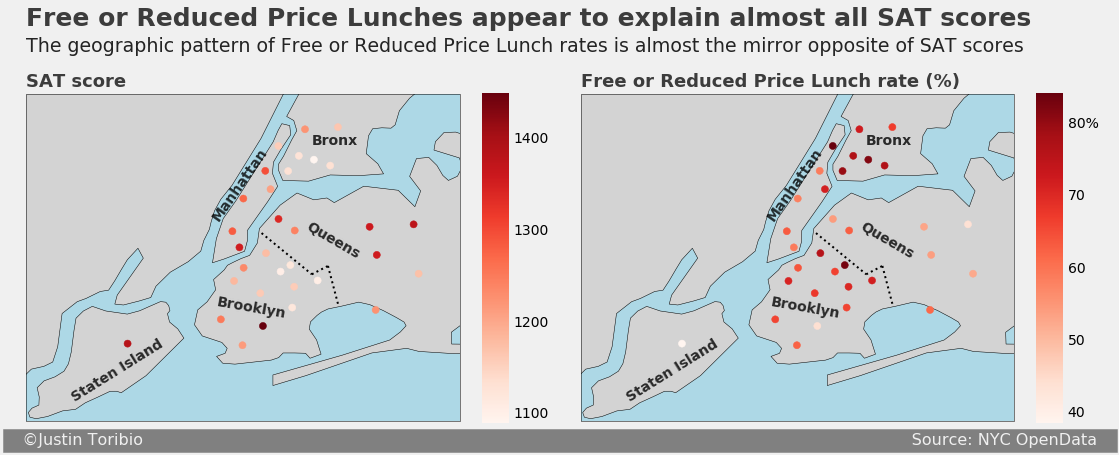

In [17]:
# Assign the title and subtitle of the map plot to variables.
title = ("Free or Reduced Price Lunches appear to explain almost all SAT"
         " scores")
subtitle = ("The geographic pattern of Free or Reduced Price Lunch rates is" 
            " almost the mirror opposite of SAT scores")

# Create and display the side by side map plot.
create_nyc_map("sat_score", "frl_percent", title=title,
               title_y_adj=-.0175, subtitle=subtitle, subtitle_y_adj=.04,
               sig_space_adj=148, map_title_1="SAT score", 
               map_title_2="Free or Reduced Price Lunch rate (%)",
               colorbar_ticks_1=[1100, 1200, 1300, 1400], 
               colorbar_ticks_2=[40, 50, 60, 70, 80], 
               colorbar_tick_labels_2=[40, 50, 60, 70, "80%"])

The FRL (Free or Reduced Price Lunch) rate appears to explain almost all SAT scores.  The 2 maps are almost mirror opposites of each other.  Districts with high FRL rates have low mean SAT scores and those with low FRL rates have high SAT scores.  This is consistent with our theory that high FRL rates indicate low-income families and neighborhoods.  This in turn would correlate with poor SAT performance due to lack of access to academic resources.  

Next we will compare the map of Hispanic student percentages with the map of Free or Reduced Price Lunch rates.

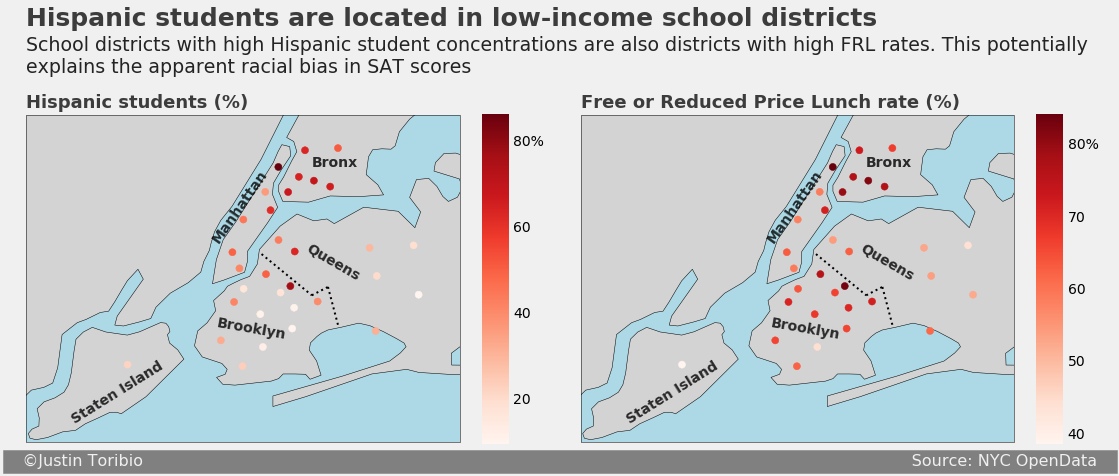

In [18]:
# Assign the title and subtitle of the map plot to variables.
title = "Hispanic students are located in low-income school districts"
subtitle = ("School districts with high Hispanic student concentrations are" 
            " also districts with high FRL rates. This potentially\n"
            "explains the apparent racial bias in SAT scores")

# Create and display the side by side map plot.
create_nyc_map("hispanic_per", "frl_percent", title=title,
               title_y_adj=.01, subtitle=subtitle, subtitle_y_adj=.04,
               sig_space_adj=148, map_title_1="Hispanic students (%)", 
               map_title_2="Free or Reduced Price Lunch rate (%)",
               colorbar_ticks_1=[20, 40, 60, 80],
               colorbar_tick_labels_1=[20, 40, 60, "80%"],
               colorbar_ticks_2=[40, 50, 60, 70, 80], 
               colorbar_tick_labels_2=[40, 50, 60, 70, "80%"])

The school districts with high Hispanic student concentrations are also districts with high FRL rates, which indicates low-income families and neighborhoods.  This is particularly true of the Bronx.  As of the 2013 Census, [the Bronx is characterized by a Hispanic majority](https://en.wikipedia.org/wiki/Demographics_of_the_Bronx) and is [NYC's poorest borough](https://mycrains.crainsnewyork.com/stats-and-the-city/2013/bronx/the-poorest-borough).  This is further evidence that socioeconomic factors explain the negative correlation between Hispanic students and SAT scores more than any kind of racial bias.  

Next we will compare the map of SAT scores with the map of ELL (English Language Learner) rates.

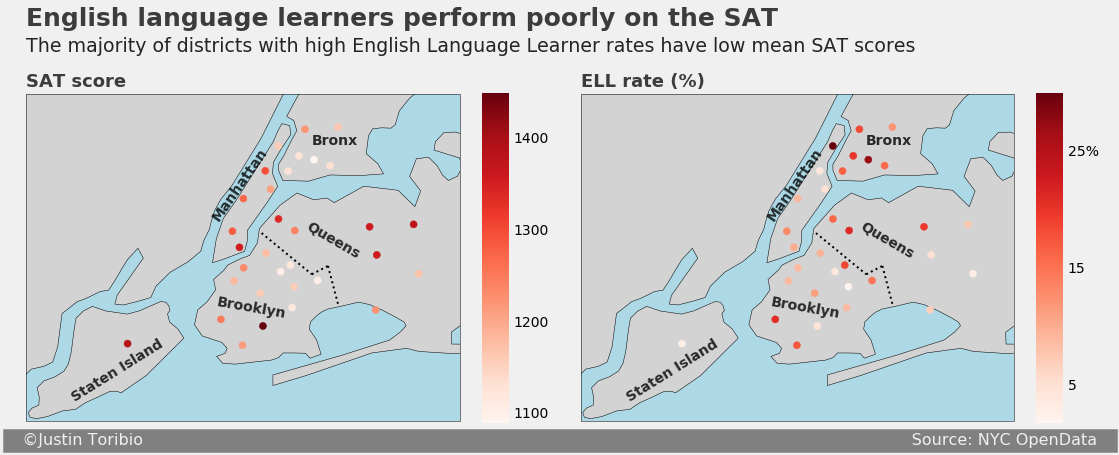

In [19]:
# Assign the title and subtitle of the map plot to variables.
title = "English language learners perform poorly on the SAT"
subtitle = ("The majority of districts with high English Language Learner" 
            " rates have low mean SAT scores")

# Create and display the side by side map plot.
create_nyc_map("sat_score", "ell_percent", title=title,
               title_y_adj=-.0175, subtitle=subtitle, subtitle_y_adj=.04,
               sig_space_adj=148, map_title_1="SAT score", 
               map_title_2="ELL rate (%)",
               colorbar_ticks_1=[1100, 1200, 1300, 1400], 
               colorbar_ticks_2=[5, 15, 25], 
               colorbar_tick_labels_2=[5, 15, "25%"])

The majority of school districts with high ELL rates have low mean SAT scores.  Again, we would expect this result since the SAT is written in English.  

Next we will compare the map of Hispanic student percentages with the map of English Language Learner rates.

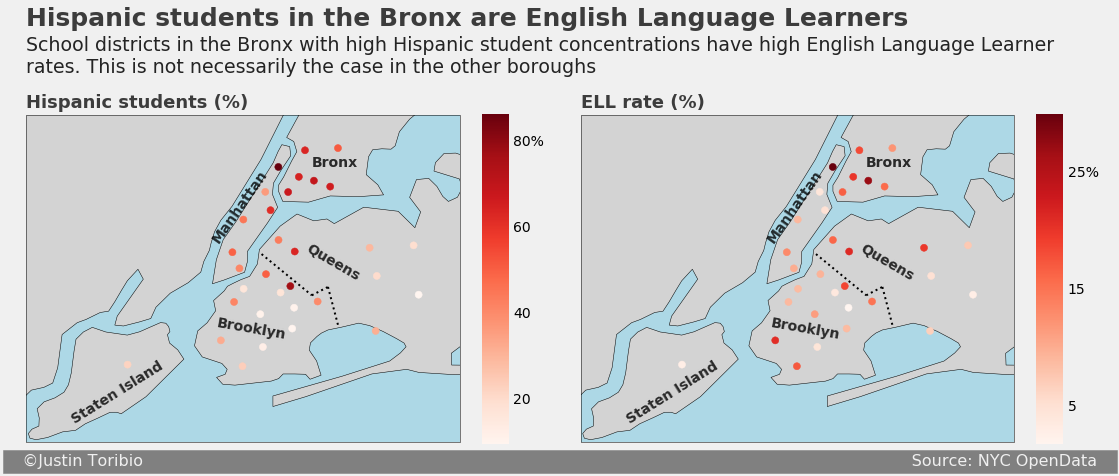

In [20]:
# Assign the title and subtitle of the map plot to variables.
title = "Hispanic students in the Bronx are English Language Learners"
subtitle = ("School districts in the Bronx with high Hispanic student"
            " concentrations have high English Language Learner\n"
            "rates. This is not necessarily the case in the other boroughs")

# Create and display the side by side map plot.
create_nyc_map("hispanic_per", "ell_percent", title=title,
               title_y_adj=.01, subtitle=subtitle, subtitle_y_adj=.04,
               sig_space_adj=148, map_title_1="Hispanic students (%)", 
               map_title_2="ELL rate (%)",
               colorbar_ticks_1=[20, 40, 60, 80],
               colorbar_tick_labels_1=[20, 40, 60, "80%"], 
               colorbar_ticks_2=[5, 15, 25], 
               colorbar_tick_labels_2=[5, 15, "25%"])

The majority of districts with high Hispanic student percentages have high ELL rates.  This is particularly true in the Bronx, which we already know has a Hispanic majority.  This is an intuitive result since many of the Hispanic residents could be immigrants that speak Spanish as their primary language.

This is not necessarily the case in the other boroughs.  A few districts in Manhattan have high Hispanic student concentrations but low ELL rates.  

All of our findings suggest that socioeconomic factors and English language learning explain the relationships we have observed between SAT scores and racial student groups more than any type of inherent racial bias in the SAT.  

# School and class sizes may influence SAT scores  

The 12th and 13th column names in the [initial correlation bar plot above](#Creating-the-correlation-bar-plot) (`"AVERAGE CLASS SIZE"` and `"NUMBER OF STUDENTS / SEATS FILLED"`) both pertain to class size data.  We will display the bar plot again showing only these columns.

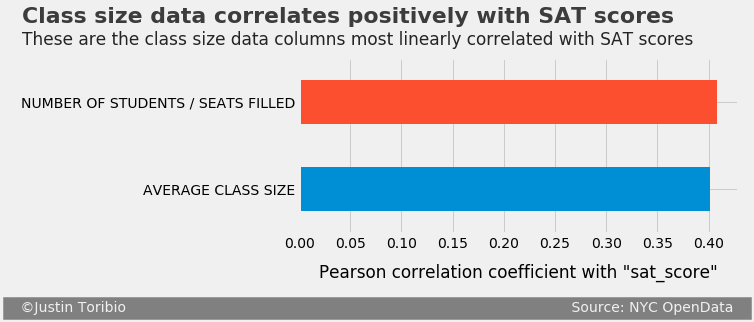

In [21]:
# Assign the column names to be viewed and the text of the bar plot to
# variables.
columns = ["AVERAGE CLASS SIZE", "NUMBER OF STUDENTS / SEATS FILLED"]
title = "Class size data correlates positively with SAT scores"
subtitle = ("These are the class size data columns most linearly correlated"
            " with SAT scores")
x_axis_label = 'Pearson correlation coefficient with "sat_score"'

# Create and display the bar plot.
corr_bar_plot(data, "sat_score", columns=columns,
              fig_size=(7, 3), x_axis_label=x_axis_label,
              title=title, title_y_adj=-3.1, title_x_adj=-.271,
              sub=subtitle, sub_y_adj=-1.35, sub_x_adj=-.271,
              sig_y_adj=2.6, sig_x_adj=-.285, sig_space_adj=97)

The total number of students and average class sizes are both positively correlated with SAT scores.  Next we will view the scatter plots of `"AVERAGE CLASS SIZE"` and `"NUMBER OF STUDENTS / SEATS FILLED"` against `"sat_score"` to get a visual representation of their relationships.

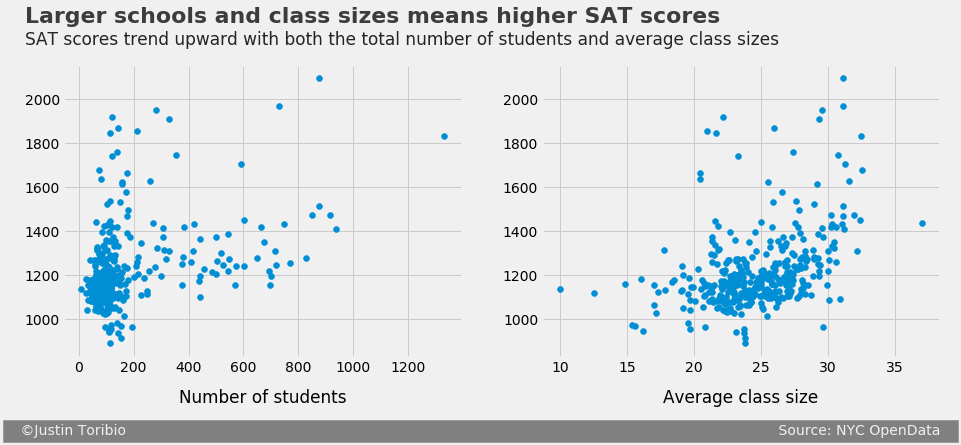

In [22]:
# Assign the text of the scatter plots to variables.
title = "Larger schools and class sizes means higher SAT scores"
subtitle = ("SAT scores trend upward with both the total number of students"
            " and average class sizes")
x_axis_label_1 = "Number of students"
x_axis_label_2 = "Average class size"
signature = ("   ©Justin Toribio"
             + " "*145
             + "Source: NYC OpenData   ")

# Define the plot style and create the figure object.
plt.close("all")
style.use("fivethirtyeight")
fig = plt.figure(figsize=(14,5))

# Create the left scatter plot and add the text of the entire plot.
ax1 = fig.add_subplot(121)
ax1.scatter(data["NUMBER OF STUDENTS / SEATS FILLED"], data["sat_score"])
ax1.set_xlabel(x_axis_label_1, labelpad=14)
ax1.yaxis.label.set_visible(False)
ax1.text(s=title, x=-195, y=2350, fontsize=22, weight="bold", alpha=.75)
ax1.text(s=subtitle, x=-195, y=2250, fontsize=17, alpha=.85)
ax1.text(s=signature, x=-260, y=470, fontsize=14, color="#f0f0f0",
         backgroundcolor="grey")

# Create the right scatter plot and display the entire plot.
ax2 = fig.add_subplot(122)
ax2.scatter(data["AVERAGE CLASS SIZE"], data["sat_score"])
ax2.set_xlabel(x_axis_label_2, labelpad=14)
ax2.yaxis.label.set_visible(False)
plt.show()

SAT scores trend upward with both the total number of students and average class sizes.  The minimum mean SAT score increases as the number of students increases.  In the right scatter plot, the main cluster of SAT scores trends upward as average class size increases.  

A possible explanation for these relationships could also be economic in nature.  Schools with larger student populations and class sizes probably have the funding necessary to support large student bodies (i.e. funding for teachers, classrooms, buildings, equipment etc...).  This would imply these schools are located in high-income neighborhoods and consist of students mainly from high-income families.  We discovered earlier in this project that SAT scores have a strong positive correlation with the economic status of the students' families and neighborhoods. 

To test this hypothesis, we will look at the Pearson correlation coefficients between `"AVERAGE CLASS SIZE"` and `"NUMBER OF STUDENTS / SEATS FILLED"` with `"frl_percent"` (the Free or Reduced Price Lunch, or FRL, rate).   Remember, a high FRL rate (a high concentration of students receiving free or reduced price lunches) indicates the school has a high concentration of students that come from low-income families.

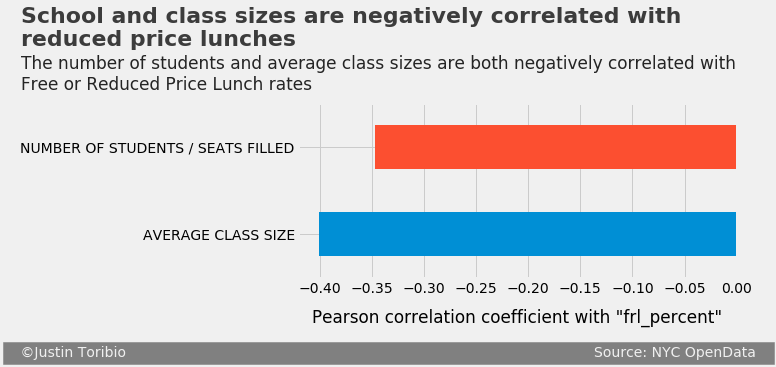

In [23]:
# Assign the column names to be viewed and the text of the bar plot to
# variables.
columns = ["AVERAGE CLASS SIZE", "NUMBER OF STUDENTS / SEATS FILLED"]
title = ("School and class sizes are negatively correlated with\n"
         "reduced price lunches")
subtitle = ("The number of students and average class sizes are both" 
            " negatively correlated with\n" 
            "Free or Reduced Price Lunch rates")
x_axis_label = 'Pearson correlation coefficient with "frl_percent"'

# Create and display the bar plot.
corr_bar_plot(data, "frl_percent", columns=columns,
              fig_size=(7, 3), x_axis_label=x_axis_label,
              title=title, title_y_adj=-2.85, title_x_adj=-.687,
              sub=subtitle, sub_y_adj=-1.35, sub_x_adj=-.687,
              sig_y_adj=2.6, sig_x_adj=-.7, sig_space_adj=102)

The number of students and average class sizes are both negatively correlated with FRL rates, which is consistent with our hypothesis.  Next we will view the scatter plots of `"AVERAGE CLASS SIZE"` and `"NUMBER OF STUDENTS / SEATS FILLED"` against `"frl_percent"` to get a visual representation of their relationships.

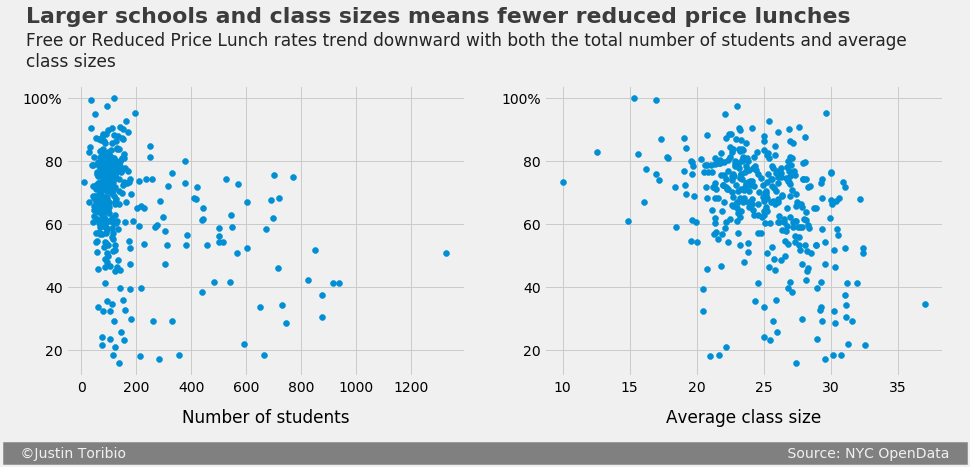

In [24]:
# Assign the text of the scatter plots to variables.
title = "Larger schools and class sizes means fewer reduced price lunches"
subtitle = ("Free or Reduced Price Lunch rates trend downward with both"
            " the total number of students and average\n"
            "class sizes")
x_axis_label_1 = "Number of students"
x_axis_label_2 = "Average class size"
signature = ("   ©Justin Toribio"
             + " "*147
             + "Source: NYC OpenData   ")

# Define the plot style and create the figure object.
plt.close("all")
style.use("fivethirtyeight")
fig = plt.figure(figsize=(14,5))

# Create the left scatter plot and add the text of the entire plot.
ax1 = fig.add_subplot(121)
ax1.scatter(data["NUMBER OF STUDENTS / SEATS FILLED"], data["frl_percent"])
ax1.set_yticklabels(labels=["0", "20", "40", "60", "80", "100%"])
ax1.set_xlabel(x_axis_label_1, labelpad=14)
ax1.yaxis.label.set_visible(False)
ax1.text(s=title, x=-201, y=124, fontsize=22, weight="bold", alpha=.75)
ax1.text(s=subtitle, x=-201, y=110, fontsize=17, alpha=.85)
ax1.text(s=signature, x=-270, y=-14, fontsize=14, color="#f0f0f0",
         backgroundcolor="grey")

# Create the right scatter plot and display the entire plot.
ax2 = fig.add_subplot(122)
ax2.scatter(data["AVERAGE CLASS SIZE"], data["frl_percent"])
ax2.set_yticklabels(labels=["0", "20", "40", "60", "80", "100%"])
ax2.set_xlabel(x_axis_label_2, labelpad=14)
ax2.yaxis.label.set_visible(False)
plt.show()

FRL rates trend downward with both the total number of students and average class sizes.  The maximum FRL rate decreases as both the number of students and average class size increases.  Again, this is consistent with our hypothesis.  

Next we will compare the map of school sizes with the map of FRL rates, by school district.

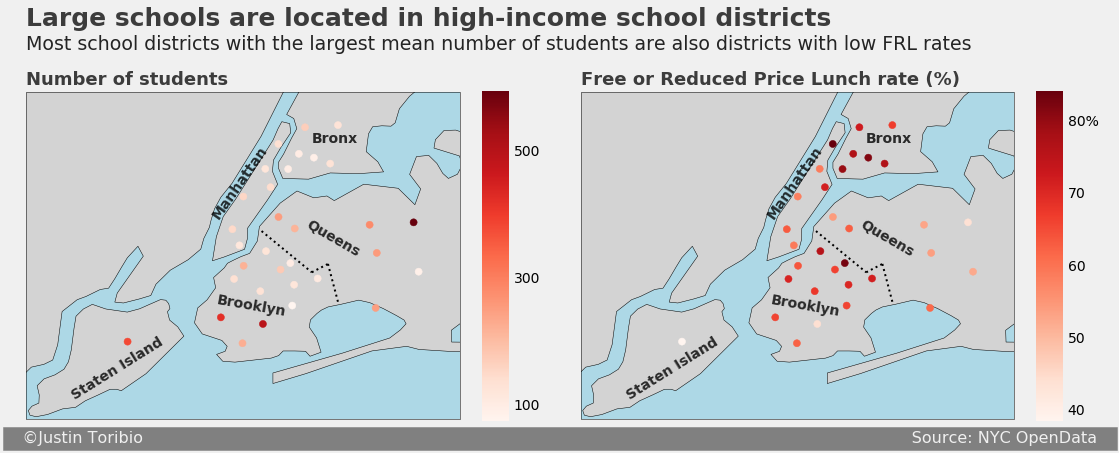

In [25]:
# Assign the title and subtitle of the map plot to variables.
title = "Large schools are located in high-income school districts"
subtitle = ("Most school districts with the largest mean number of students" 
            " are also districts with low FRL rates")

# Create and display the side by side map plot.
create_nyc_map("NUMBER OF STUDENTS / SEATS FILLED", "frl_percent", title=title,
               title_y_adj=-.02, subtitle=subtitle, subtitle_y_adj=.04,
               sig_space_adj=148, map_title_1="Number of students", 
               map_title_2="Free or Reduced Price Lunch rate (%)",
               colorbar_ticks_1=[100, 300, 500],
               colorbar_ticks_2=[40, 50, 60, 70, 80], 
               colorbar_tick_labels_2=[40, 50, 60, 70, "80%"])

Most school districts with the largest mean number of students (darkest red dots in the left map) also have low FRL rates (lightest red dots in the right map), indicating they are in high-income neighborhoods.  The majority of districts with a low mean number of students have high FRL rates, indicating they are in low-income neighborhoods.  These findings are consistent with our hypothesis.  

Next we will compare the map of average class sizes with the map of FRL rates, by school district.

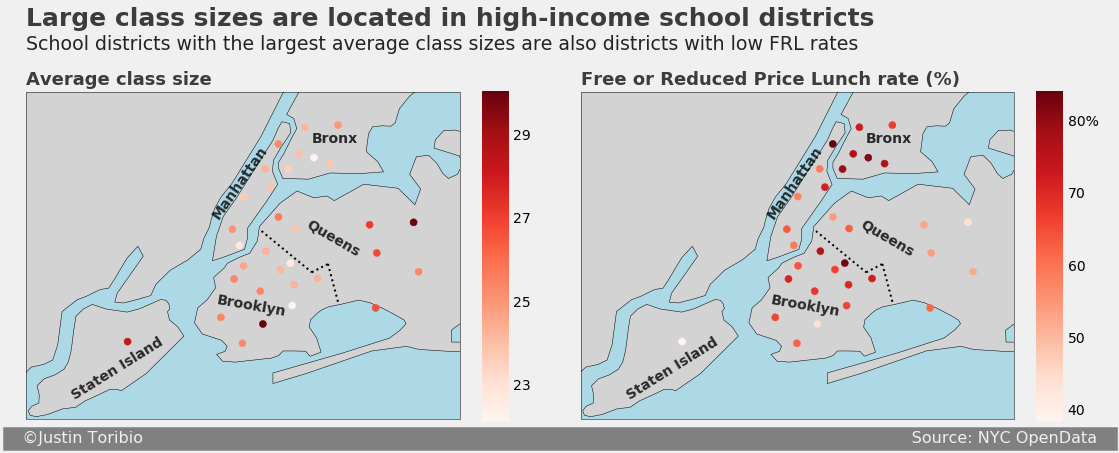

In [26]:
# Assign the title and subtitle of the map plot to variables.
title = "Large class sizes are located in high-income school districts"
subtitle = ("School districts with the largest average class sizes" 
            " are also districts with low FRL rates")

# Create and display the side by side map plot.
create_nyc_map("AVERAGE CLASS SIZE", "frl_percent", title=title,
               title_y_adj=-.02, subtitle=subtitle, subtitle_y_adj=.04,
               sig_space_adj=148, map_title_1="Average class size", 
               map_title_2="Free or Reduced Price Lunch rate (%)",
               colorbar_ticks_1=[23, 25, 27, 29],
               colorbar_ticks_2=[40, 50, 60, 70, 80], 
               colorbar_tick_labels_2=[40, 50, 60, 70, "80%"])

School districts with the largest average class sizes (darkest red dots in the left map) also have low FRL rates (lightest red dots in the right map), indicating they are in high-income neighborhoods. The majority of districts with small average class sizes have high FRL rates, indicating they are in low-income neighborhoods. These findings are consistent with our hypothesis.

Similar to the apparent racial bias we discovered in the data earlier, economic factors appear to explain the relationships between school and class sizes with SAT scores.  All of these findings provide further evidence that the economic status of the students' families and neighborhoods are the biggest drivers of SAT performance in our dataset.  

# There is no insight to gain from AP data

The 14th through 16th column names in the [initial correlation bar plot above](#Creating-the-correlation-bar-plot) (`"Num of AP Exams Passed"` to `"Num of AP Test Takers"`) all pertain to AP (advanced placement) data.  There is not much insight to gain from these columns, which represent the number of AP exams passed or taken and are all positively correlated with `"sat_score"`.  

AP exams are optional exams students can take to earn college credit in a particular subject.  Proactive students earning college credit in advance are reasonably expected to perform well on the SAT.  Therefore, we will not explore any of these columns further.  

# There is no insight to gain from Graduation data

The last 13 column names in the [initial correlation bar plot above](#Creating-the-correlation-bar-plot) (`"Dropped Out - % of cohort"` to `"Total Grads - n"`) all pertain to graduation data.  There is not much insight to gain from any of these columns either.  

There are three different categories of high school diplomas offered to graduating students in New York State: a regular diploma called the Regents, the Regents Diploma with Advanced Designation, and the Local Diploma.  A Local Diploma is an option for students who can't get above a score of 65 on all of their Regents Exams, but can get above a 45.  A Regents Diploma with Advanced Designation is more difficult to earn than a regular Regents Diploma.

The first 5 column names in this group (`"Dropped Out - % of cohort"` to `"Regents w/o Advanced - % of grads"`) are all negatively correlated with SAT scores.  These columns represent the percent of cohorts/graduates who either dropped out, are still enrolled, or received a Local or regular Regents diploma.  We would expect high values in these columns to correlate with low SAT scores.  Therefore, we will not explore any of these columns further.  

The last 8 column names in this group (`"Advanced Regents - % of grads"` to `"Total Grads - n"`) are all positively correlated with SAT scores.  These columns represent the number/percent of cohorts/graduates who either received an Advanced Regents diploma, any kind of Regents diploma (thus NOT a local diploma), or graduated.  We would expect high values in these columns to correlate with high SAT scores.  Therefore, we will not explore any of these columns further.  

# Conclusion  

The goal of this project was to examine if the SAT is unfair to any particular groups of students.  We explored SAT and NYC high school data to answer this question.  We looked deeper into the data columns that were most correlated with SAT scores and created various data visualizations to aid our investigation.  

At first, there appeared to be some racial bias in the SAT, in favor of White and Asian students and against Hispanic students.  It also appeared that schools with larger student populations and class sizes outperformed on the SAT.  However, further analysis suggested that the socioeconomic status of the students' families and whether they are English language learners were the most relevant factors tied to SAT performance.  

We could examine this dataset from many more angles and I encourage anyone to expand upon this project to uncover even more insights.